# [Ateliers: Technologies de l'intelligence Artificielle](https://github.com/wikistat/AI-Frameworks)

<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" width=400, style="max-width: 150px; display: inline"  alt="Wikistat"/></a>
<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" width=400,  style="float:right;  display: inline" alt="IMT"/> </a>
    
</center>

# Introduction to Reinforcement Learning 
 
Source : [https://github.com/ageron/handson-ml](https://github.com/ageron/handson-ml)


https://github.com/breeko/Simple-Reinforcement-Learning-with-Tensorflow/blob/master/Part%202%20-%20Policy-based%20Agents%20with%20Keras.ipynb

# AI Gym Librairie
<a href="https://gym.openai.com/" ><img src="https://gym.openai.com/assets/dist/home/header/home-icon-54c30e2345.svg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

In this notebook we will be using [OpenAI gym](https://gym.openai.com/), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with.

## Import librairies

In [1]:
import numpy as np
import random
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib inline
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.initializers as ki
import tensorflow.keras.optimizers as ko
import tensorflow.keras.losses as klo
import tensorflow.keras.backend as K


# Gym Librairy
import gym

def display_environment(env):
    img = env.render(mode="rgb_array")
    env.close()
    plt.figure(figsize=(5,4))
    plt.imshow(img)
    plt.axis("off")

## Gym Environment 

Next we will load the MsPacman environment, version 0.

In [2]:
env = gym.make('MsPacman-v0')

Let's initialize the environment by calling is `reset()` method. This returns an observation:

In [3]:
obs = env.reset()

Observations vary depending on the environment. In this case it is an RGB image represented as a 3D NumPy array of shape [width, height, channels] (with 3 channels: Red, Green and Blue). In other environments it may return different objects, as we will see later.

In [4]:
obs.shape

(210, 160, 3)

An environment can be visualized by calling its `render()` method, and you can pick the rendering mode (the rendering options depend on the environment). In this example we will set `mode="rgb_array"` to get an image of the environment as a NumPy array:

In [5]:
img = env.render(mode="rgb_array")

Let's plot this image:

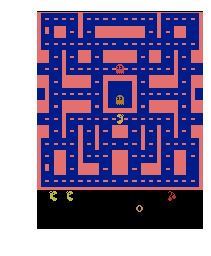

In [6]:
plt.figure(figsize=(5,4))
plt.imshow(img)
plt.axis("off")
plt.show()

Welcome back to the 1980s! :)

In this environment, the rendered image is simply equal to the observation (but in many environments this is not the case):

In [7]:
(img == obs).all()

True

Let's create a little helper function to plot an environment:

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [8]:
env.action_space

Discrete(9)

`Discrete(9)` means that the possible actions are integers 0 through 8, which represents the 9 possible positions of the joystick (0=center, 1=up, 2=right, 3=left, 4=down, 5=upper-right, 6=upper-left, 7=lower-right, 8=lower-left).

Next we need to tell the environment which action to play, and it will compute the next step of the game. Let's go left for 110 steps, then lower left for 40 steps:

In [9]:
env.reset()
for step in range(110):
    env.step(3) #left
for step in range(40):
    env.step(8) #lower-left

Where are we now?

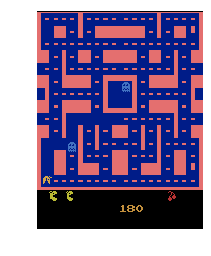

In [10]:
display_environment(env)

The `step()` function actually returns several important objects:

In [11]:
obs, reward, done, info = env.step(0)

The observation tells the agent what the environment looks like, as discussed earlier. This is a 210x160 RGB image:

In [12]:
obs.shape

(210, 160, 3)

The environment also tells the agent how much reward it got during the last step:

In [13]:
reward

0.0

When the game is over, the environment returns `done=True`:

In [14]:
done

False

Finally, `info` is an environment-specific dictionary that can provide some extra information about the internal state of the environment. This is useful for debugging, but your agent should not use this information for learning (it would be cheating).

In [15]:
info

{'ale.lives': 3}

Let's play one full game (with 3 lives), by moving in random directions for 10 steps at a time, recording each frame:

In [16]:
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = env.render(mode="rgb_array")
    frames.append(img)
    if step % n_change_steps == 0:
        action = env.action_space.sample() # play randomly
    obs, reward, done, info = env.step(action)
    if done:
        break

Now show the animation (it's a bit jittery within Jupyter):

In [17]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

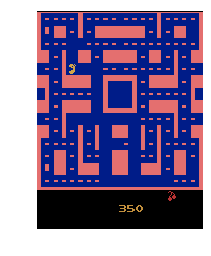

In [18]:
HTML(plot_animation(frames).to_html5_video())


Once you have finished playing with an environment, you should close it to free up resources:

In [19]:
env.close()

To code our first learning agent, we will be using a simpler environment: the Cart-Pole. 

# A simple environment: the Cart-Pole

The Cart-Pole is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

In [20]:
env = gym.make("CartPole-v0")

In [21]:
obs = env.reset()
obs

array([ 0.01235897,  0.03984409,  0.01373941, -0.047498  ])

(-0.5, 1199.5, 799.5, -0.5)

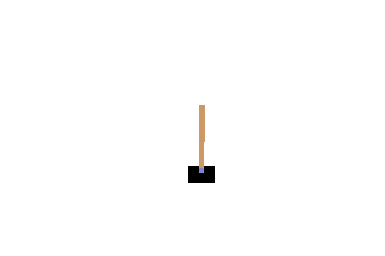

In [22]:
img = env.render(mode = "rgb_array")
env.close()
plt.imshow(img)
plt.axis("off")

The observation is a 1D NumPy array composed of 4 floats: they represent the cart's horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity.

In [23]:
env.action_space

Discrete(2)

Yep, just two possible actions: accelerate towards the left or towards the right. Let's push the cart left until the pole falls:

In [24]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(0)
    if done:
        break

(-0.5, 1199.5, 799.5, -0.5)

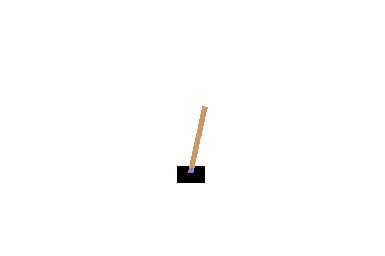

In [25]:
img = env.render(mode = "rgb_array")
env.close()
plt.imshow(img)
plt.axis("off")

In [26]:
img.shape

(800, 1200, 3)

Notice that the game is over when the pole tilts too much, not when it actually falls. Now let's reset the environment and push the cart to right instead:

In [27]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(1)
    if done:
        break

(-0.5, 1199.5, 799.5, -0.5)

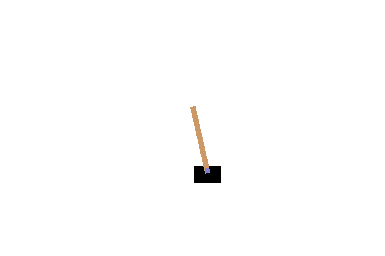

In [28]:
img = env.render(mode = "rgb_array")
env.close()
plt.imshow(img)
plt.axis("off")


Looks like it's doing what we're telling it to do. Now how can we make the poll remain upright? We will need to define a _policy_ for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

In [29]:
# Try running environment with random actions
env.reset()
reward_sum = 0
num_games = 10
num_game = 0
while num_game < num_games:
#     env.render()
    observation, reward, done, _ = env.step(env.action_space.sample())
    reward_sum += reward
    if done:
        print("Reward for this episode was: {}".format(reward_sum))
        reward_sum = 0
        num_game += 1
        env.reset()

Reward for this episode was: 13.0
Reward for this episode was: 17.0
Reward for this episode was: 10.0
Reward for this episode was: 13.0
Reward for this episode was: 27.0
Reward for this episode was: 15.0
Reward for this episode was: 17.0
Reward for this episode was: 13.0
Reward for this episode was: 31.0
Reward for this episode was: 21.0


# A simple hard-coded policy

Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left, and _vice versa_. Let's see if that works:

In [30]:
# Try running environment with random actions
reward_sum = 0
num_games = 10
num_game = 0
n_step_before_fail = 0
obs = env.reset()
reward
while num_game < num_games:
    # hard-coded policy
    position, velocity, angle, angular_velocity = obs
    if angle < 0:
        action = 0
    else:
        action = 1
    obs, reward, done, info = env.step(action)
    n_step_before_fail +=1
    reward_sum += reward
    if done:
        print("Reward for this episode was: {} ({} step)".format(reward_sum, n_step_before_fail))
        reward_sum = 0
        num_game += 1
        n_step_before_fail=0
        env.reset()
        
    

Reward for this episode was: 37.0 (37 step)
Reward for this episode was: 43.0 (43 step)
Reward for this episode was: 41.0 (41 step)
Reward for this episode was: 65.0 (65 step)
Reward for this episode was: 38.0 (38 step)
Reward for this episode was: 41.0 (41 step)
Reward for this episode was: 25.0 (25 step)
Reward for this episode was: 29.0 (29 step)
Reward for this episode was: 40.0 (40 step)
Reward for this episode was: 45.0 (45 step)


In [31]:
frames = []

n_max_steps = 1000
n_change_steps = 10
n_step_before_fail = 0
obs = env.reset()
for step in range(n_max_steps):
    img = env.render(mode = "rgb_array")
    env.close()
    frames.append(img)

    # hard-coded policy
    position, velocity, angle, angular_velocity = obs
    if angle < 0:
        action = 0
    else:
        action = 1
    n_step_before_fail +=1
    obs, reward, done, info = env.step(action)
    if done:
        break
n_step_before_fail

39

In [32]:
img.shape

(800, 1200, 3)

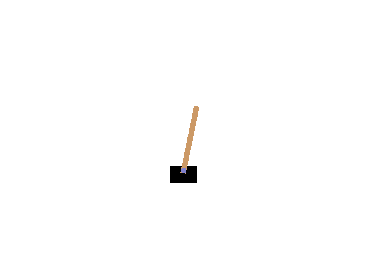

In [33]:
HTML(plot_animation(frames).to_html5_video())

Nope, the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

# Neural Network Policies

Let's create a neural network that will take observations as inputs, and output the action to take for each observation. To choose an action, the network will first estimate a probability for each action, then select an action randomly according to the estimated probabilities. In the case of the Cart-Pole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability `p` of the action 0 (left), and of course the probability of action 1 (right) will be `1 - p`.

Note: instead of using the `fully_connected()` function from the `tensorflow.contrib.layers` module (as in the book), we now use the `dense()` function from the `tf.layers` module, which did not exist when this chapter was written. This is preferable because anything in contrib may change or be deleted without notice, while `tf.layers` is part of the official API. As you will see, the code is mostly the same.

The main differences relevant to this chapter are:
* the `_fn` suffix was removed in all the parameters that had it (for example the `activation_fn` parameter was renamed to `activation`).
* the `weights` parameter was renamed to `kernel`,
* the default activation is `None` instead of `tf.nn.relu`

In [34]:


# 1. Specify the network architecture
n_inputs = 4  # == env.observation_space.shape[0]
n_hidden = 4  # it's a simple task, we don't need more than this
n_outputs = 1 # only outputs the probability of accelerating left
initializer = ki.VarianceScaling()

# 2. Build the neural network
policy_network=km.Sequential()
policy_network.add(kl.Dense(n_hidden, input_shape = (n_inputs,), activation = "relu", kernel_initializer = initializer))
policy_network.add(kl.Dense(n_outputs, activation = "sigmoid", kernel_initializer = initializer))

policy_network.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [35]:
obs = env.reset()
# Generate the probability of action 0
p_left = policy_network.predict(np.expand_dims(obs,axis=0))
# Choose and action according to the previously generated probability
action = 0 if random.uniform(0,1)< p_left else 1 

In this particular environment, the past actions and observations can safely be ignored, since each observation contains the environment's full state. If there were some hidden state then you may need to consider past actions and observations in order to try to infer the hidden state of the environment. For example, if the environment only revealed the position of the cart but not its velocity, you would have to consider not only the current observation but also the previous observation in order to estimate the current velocity. Another example is if the observations are noisy: you may want to use the past few observations to estimate the most likely current state. Our problem is thus as simple as can be: the current observation is noise-free and contains the environment's full state.

You may wonder why we are picking a random action based on the probability given by the policy network, rather than just picking the action with the highest probability. This approach lets the agent find the right balance between _exploring_ new actions and _exploiting_ the actions that are known to work well. Here's an analogy: suppose you go to a restaurant for the first time, and all the dishes look equally appealing so you randomly pick one. If it turns out to be good, you can increase the probability to order it next time, but you shouldn't increase that probability to 100%, or else you will never try out the other dishes, some of which may be even better than the one you tried.

In [36]:
# Try running environment with random actions
reward_sum = 0
num_games = 10
num_game = 0
n_step_before_fail
obs = env.reset()
reward
while num_game < num_games:
    # hard-coded policy
    p_left = policy_network.predict(np.expand_dims(obs,axis=0))
    action = 0 if random.uniform(0,1)< p_left else 1 
    obs, reward, done, info = env.step(action)
    n_step_before_fail +=1
    reward_sum += reward
    if done:
        print("Reward for this episode was: {} ({} step)".format(reward_sum, n_step_before_fail))
        reward_sum = 0
        num_game += 1
        n_step_before_fail=0
        env.reset()

Reward for this episode was: 15.0 (54 step)
Reward for this episode was: 11.0 (11 step)
Reward for this episode was: 19.0 (19 step)
Reward for this episode was: 62.0 (62 step)
Reward for this episode was: 11.0 (11 step)
Reward for this episode was: 26.0 (26 step)
Reward for this episode was: 20.0 (20 step)
Reward for this episode was: 29.0 (29 step)
Reward for this episode was: 15.0 (15 step)
Reward for this episode was: 22.0 (22 step)


Let's randomly initialize this policy neural network and use it to play one game:

In [37]:
n_max_steps = 1000
frames = []

n_step_before_fail = 0

obs = env.reset()
for step in range(n_max_steps):
    img = env.render(mode = "rgb_array")
    env.close()
    frames.append(img)
    p_left = policy_network.predict(np.expand_dims(obs,axis=0))
    action = 0 if random.uniform(0,1)< p_left else 1 
    obs, reward, done, info = env.step(action)
    n_step_before_fail +=1

    if done:
        break

env.close()
n_step_before_fail


13

Now let's look at how well this randomly initialized policy network performed:

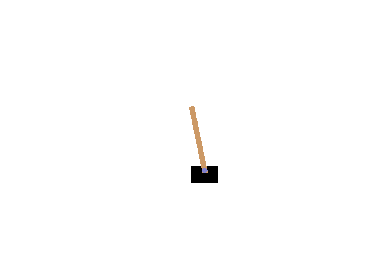

In [38]:
plt.close()
HTML(plot_animation(frames).to_html5_video())

Yeah... pretty bad. The neural network will have to learn to do better. First let's see if it is capable of learning the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right. The following code defines the same neural network but we add the target probabilities `y`, and the training operations (`cross_entropy`,  `optimizer` and `training_op`):

In [39]:
learning_rate = 0.01


policy_network=km.Sequential()
policy_network.add(kl.Dense(n_hidden, input_shape = (n_inputs,), activation = "relu", kernel_initializer = initializer))
policy_network.add(kl.Dense(n_outputs, activation = "sigmoid", kernel_initializer = initializer))

# apprentissage
adam = ko.Adam(lr = learning_rate)
policy_network.compile(loss='binary_crossentropy',optimizer=ko.Adam(lr = learning_rate),metrics=['accuracy'])


We can make the same net play in 10 different environments in parallel, and train for 1000 iterations. We also reset environments when they are done.

In [40]:
n_environments = 10
n_iterations = 2000

envs = [gym.make("CartPole-v0") for _ in range(n_environments)]
observations = np.array([env.reset() for env in envs])


for iteration in range(n_iterations):
    target_probas = np.array([(1 if obs[2] < 0 else 0) for obs in observations]) # if angle<0 we want proba(left)=1., or else proba(left)=0.
    policy_network.train_on_batch(observations, target_probas)  # one batch iteration
    
    # Generate probablity and observation on ntext step
    p_lefts = policy_network.predict(observations)
    actions = [0 if random.uniform(0,1)< p_left else 1 for p_left in p_lefts]
    
    # Compute next state
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

In [41]:
# Try running environment with random actions
reward_sum = 0
num_games = 10
num_game = 0
n_step_before_fail
obs = env.reset()
reward
while num_game < num_games:
    # hard-coded policy
    p_left = policy_network.predict(np.expand_dims(obs,axis=0))
    action = 0 if random.uniform(0,1)< p_left else 1 
    obs, reward, done, info = env.step(action)
    n_step_before_fail +=1
    reward_sum += reward
    if done:
        print("Reward for this episode was: {} ({} step)".format(reward_sum, n_step_before_fail))
        reward_sum = 0
        num_game += 1
        n_step_before_fail=0
        env.reset()

Reward for this episode was: 33.0 (46 step)
Reward for this episode was: 53.0 (53 step)
Reward for this episode was: 41.0 (41 step)
Reward for this episode was: 35.0 (35 step)
Reward for this episode was: 61.0 (61 step)
Reward for this episode was: 42.0 (42 step)
Reward for this episode was: 45.0 (45 step)
Reward for this episode was: 26.0 (26 step)
Reward for this episode was: 55.0 (55 step)
Reward for this episode was: 54.0 (54 step)


In [42]:
n_max_steps = 10000
frames = []

n_step_before_fail = 0

obs = env.reset()
for step in range(n_max_steps):
    img = env.render(mode = "rgb_array")
    env.close()
    frames.append(img)
    p_left = policy_network.predict(np.expand_dims(obs,axis=0))
    action = 0 if random.uniform(0,1)< p_left else 1 
    obs, reward, done, info = env.step(action)
    n_step_before_fail +=1

    if done:
        break

env.close()
n_step_before_fail       

31

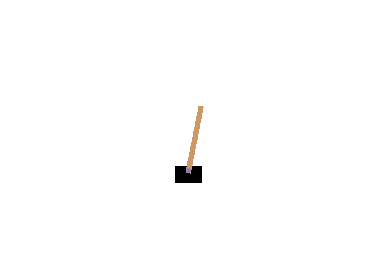

In [43]:
plt.close()
HTML(plot_animation(frames).to_html5_video())

Looks like it learned the policy correctly. Now let's see if it can learn a better policy on its own.

# Policy Gradients

To train this neural network we will need to define the target probabilities `y`. If an action is good we should increase its probability, and conversely if it is bad we should reduce it. But how do we know whether an action is good or bad? The problem is that most actions have delayed effects, so when you win or lose points in a game, it is not clear which actions contributed to this result: was it just the last action? Or the last 10? Or just one action 50 steps earlier? This is called the _credit assignment problem_.

The _Policy Gradients_ algorithm tackles this problem by first playing multiple games, then making the actions in good games slightly more likely, while actions in bad games are made slightly less likely. First we play, then we go back and think about what we did.

Once again define the same neural network architecture

In [54]:
def get_policy_model(env, hidden_layer_neurons, lr):
    dimen = env.reset().shape
    num_actions = 1
    inp = kl.Input(shape=dimen,name="input_x")
    adv = kl.Input(shape=[1], name="advantages")
    x = kl.Dense(hidden_layer_neurons, 
                     activation="relu", 
                     use_bias=False,
                     kernel_initializer=initializer,
                     name="dense_1")(inp)
    out = kl.Dense(num_actions, 
                       activation="sigmoid", 
                       kernel_initializer=initializer,
                       use_bias=False,
                       name="out")(x)

    def my_custom_loss(y_true, y_pred):
       
        log_lik = - (y_true*K.log(y_pred) + (1-y_true)*K.log(1-y_pred))
        return K.mean(log_lik * adv, keepdims=True)
        
    model_train = km.Model(inputs=[inp, adv], outputs=out)
    model_train.compile(loss=my_custom_loss, optimizer=ko.Adam(lr))
    model_predict = km.Model(inputs=[inp], outputs=out)
    return model_train, model_predict

In [55]:
def discount_rewards(r, gamma=0.99):
    """Takes 1d float array of rewards and computes discounted reward
    e.g. f([1, 1, 1], 0.99) -> [2.9701, 1.99, 1]
    """
    prior = 0
    out = []
    for val in r:
        new_val = val + prior * gamma
        out.append(new_val)
        prior = new_val
    return np.array(out[::-1])

In [56]:
# Constants defining our neural network
hidden_layer_neurons = 8
gamma = .99
dimen = len(env.reset())
print_every = 100
batch_size = 50
num_episodes = 10000
render = False
lr = 1e-2
goal = 190

In [57]:
# See our trained bot in action
def score_model(model, num_tests, render=False):
    scores = []    
    for num_test in range(num_tests):
        observation = env.reset()
        reward_sum = 0
        while True:
            if render:
                env.render()

            state = np.reshape(observation, [1, dimen])
            predict = model.predict([state])[0]
            action = 0 if predict>0.5 else 1 
            observation, reward, done, _ = env.step(action)
            reward_sum += reward
            if done:
                break
        scores.append(reward_sum)
    env.close()
    return np.mean(scores)

In [58]:
model_train, model_predict = get_policy_model(env, hidden_layer_neurons, lr)
model_predict.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_x (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 32        
_________________________________________________________________
out (Dense)                  (None, 1)                 8         
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________


In [59]:
reward_sum = 0

num_actions = env.action_space.n

# Placeholders for our observations, outputs and rewards
states = np.empty(0).reshape(0,dimen)
actions = np.empty(0).reshape(0,1)
rewards = np.empty(0).reshape(0,1)
discounted_rewards = np.empty(0).reshape(0,1)

# Setting up our environment
observation = env.reset()

num_episode = 0

losses = []

while num_episode < num_episodes:
    # Append the observations to our batch
    state = np.reshape(observation, [1, dimen])
    
    predict = model_predict.predict([state])[0]
    action = 0 if random.uniform(0,1)< predict else 1 
    
    # Append the observations and outputs for learning
    states = np.vstack([states, state])
    actions = np.vstack([actions, action])
    
    # Determine the oucome of our action
    observation, reward, done, _ = env.step(action)
    reward_sum += reward
    rewards = np.vstack([rewards, reward])
    
    if done:
        # Determine standardized rewards
        discounted_rewards_episode = discount_rewards(rewards, gamma)       
        discounted_rewards = np.vstack([discounted_rewards, discounted_rewards_episode])
        
        rewards = np.empty(0).reshape(0,1)

        if (num_episode + 1) % batch_size == 0:
            discounted_rewards -= discounted_rewards.mean()
            discounted_rewards /= discounted_rewards.std()
            discounted_rewards = discounted_rewards.squeeze()
           
        
            actions_train = 1-actions
            #b()
            loss = model_train.train_on_batch([states, discounted_rewards], actions_train)
            losses.append(loss)
            
            # Clear out game variables
            states = np.empty(0).reshape(0,dimen)
            actions = np.empty(0).reshape(0,1)
            discounted_rewards = np.empty(0).reshape(0,1)

            #print(losses)
        # Print periodically
        if (num_episode + 1) % print_every == 0:
            # Print status
            score = score_model(model_predict,10)
            print("Average reward for training episode {}: {:0.2f} Test Score: {:0.2f} Loss: {:0.6f} ".format(
                (num_episode + 1), reward_sum/print_every, 
                score,
                losses[-1]))
            
            if score >= goal:
                print("Solved in {} episodes!".format(num_episode))
                break
            reward_sum = 0
                
        num_episode += 1
        observation = env.reset()
        

Average reward for training episode 100: 22.68 Test Score: 11.50 Loss: -0.003753 
Average reward for training episode 200: 23.47 Test Score: 15.80 Loss: -0.003556 
Average reward for training episode 300: 23.94 Test Score: 55.90 Loss: -0.005839 
Average reward for training episode 400: 25.25 Test Score: 48.30 Loss: -0.005718 
Average reward for training episode 500: 26.51 Test Score: 66.60 Loss: -0.008804 
Average reward for training episode 600: 28.28 Test Score: 73.60 Loss: -0.006753 
Average reward for training episode 700: 32.63 Test Score: 64.90 Loss: -0.012255 
Average reward for training episode 800: 31.18 Test Score: 74.40 Loss: -0.009130 
Average reward for training episode 900: 29.98 Test Score: 77.70 Loss: -0.011488 
Average reward for training episode 1000: 30.79 Test Score: 67.20 Loss: -0.007511 
Average reward for training episode 1100: 30.07 Test Score: 71.70 Loss: -0.016425 
Average reward for training episode 1200: 28.11 Test Score: 82.30 Loss: -0.014266 
Average rewar

In [60]:
# Try running environment with random actions
reward_sum = 0
num_games = 10
num_game = 0
n_step_before_fail = 0
obs = env.reset()
reward
while num_game < num_games:
    # hard-coded policy
    p_left = model_predict.predict(np.expand_dims(obs,axis=0))
    action = 0 if p_left[0]>0.5 else 1 
    obs, reward, done, info = env.step(action)
    n_step_before_fail +=1
    reward_sum += reward
    if done:
        print("Reward for this episode was: {} ({} step)".format(reward_sum, n_step_before_fail))
        reward_sum = 0
        num_game += 1
        n_step_before_fail=0
        env.reset()

Reward for this episode was: 200.0 (200 step)
Reward for this episode was: 153.0 (153 step)
Reward for this episode was: 195.0 (195 step)
Reward for this episode was: 200.0 (200 step)
Reward for this episode was: 200.0 (200 step)
Reward for this episode was: 89.0 (89 step)
Reward for this episode was: 200.0 (200 step)
Reward for this episode was: 200.0 (200 step)
Reward for this episode was: 200.0 (200 step)
Reward for this episode was: 99.0 (99 step)


In [63]:
n_max_steps = 10000
frames = []

n_step_before_fail = 0

obs = env.reset()
for step in range(n_max_steps):
    img = env.render(mode = "rgb_array")
    env.close()
    frames.append(img)
    p_left = model_predict.predict(np.expand_dims(obs,axis=0))
    action = 0 if p_left[0][0]>0.5 else 1 
    obs, reward, done, info = env.step(action)
    n_step_before_fail +=1

    if done:
        break

env.close()
n_step_before_fail 

200

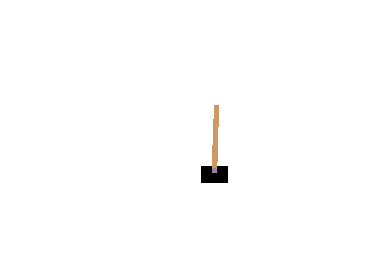

In [64]:
plt.close()
HTML(plot_animation(frames).to_html5_video())

# Markov Chains

In [ ]:
transition_probabilities = [
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to ...
        [0.0, 1.0, 0.0, 0.0],  # from s2 to ...
        [0.0, 0.0, 0.0, 1.0],  # from s3 to ...
    ]

n_max_steps = 50

def print_sequence(start_state=0):
    current_state = start_state
    print("States:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()

for _ in range(10):
    print_sequence()

# Markov Decision Process

In [ ]:
transition_probabilities = [
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]], # in s0, if action a0 then proba 0.7 to state s0 and 0.3 to state s1, etc.
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None],
    ]

rewards = [
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]],
    ]

possible_actions = [[0, 1, 2], [0, 2], [1]]

def policy_fire(state):
    return [0, 2, 1][state]

def policy_random(state):
    return np.random.choice(possible_actions[state])

def policy_safe(state):
    return [0, 0, 1][state]

class MDPEnvironment(object):
    def __init__(self, start_state=0):
        self.start_state=start_state
        self.reset()
    def reset(self):
        self.total_rewards = 0
        self.state = self.start_state
    def step(self, action):
        next_state = np.random.choice(range(3), p=transition_probabilities[self.state][action])
        reward = rewards[self.state][action][next_state]
        self.state = next_state
        self.total_rewards += reward
        return self.state, reward

def run_episode(policy, n_steps, start_state=0, display=True):
    env = MDPEnvironment()
    if display:
        print("States (+rewards):", end=" ")
    for step in range(n_steps):
        if display:
            if step == 10:
                print("...", end=" ")
            elif step < 10:
                print(env.state, end=" ")
        action = policy(env.state)
        state, reward = env.step(action)
        if display and step < 10:
            if reward:
                print("({})".format(reward), end=" ")
    if display:
        print("Total rewards =", env.total_rewards)
    return env.total_rewards

for policy in (policy_fire, policy_random, policy_safe):
    all_totals = []
    print(policy.__name__)
    for episode in range(1000):
        all_totals.append(run_episode(policy, n_steps=100, display=(episode<5)))
    print("Summary: mean={:.1f}, std={:1f}, min={}, max={}".format(np.mean(all_totals), np.std(all_totals), np.min(all_totals), np.max(all_totals)))
    print()

# Q-Learning

Q-Learning works by watching an agent play (e.g., randomly) and gradually improving its estimates of the Q-Values. Once it has accurate Q-Value estimates (or close enough), then the optimal policy consists in choosing the action that has the highest Q-Value (i.e., the greedy policy).

In [ ]:
n_states = 3
n_actions = 3
n_steps = 20000
alpha = 0.01
gamma = 0.99
exploration_policy = policy_random
q_values = np.full((n_states, n_actions), -np.inf)
for state, actions in enumerate(possible_actions):
    q_values[state][actions]=0

env = MDPEnvironment()
for step in range(n_steps):
    action = exploration_policy(env.state)
    state = env.state
    next_state, reward = env.step(action)
    next_value = np.max(q_values[next_state]) # greedy policy
    q_values[state, action] = (1-alpha)*q_values[state, action] + alpha*(reward + gamma * next_value)

In [ ]:
def optimal_policy(state):
    return np.argmax(q_values[state])

In [ ]:
q_values

In [ ]:
all_totals = []
for episode in range(1000):
    all_totals.append(run_episode(optimal_policy, n_steps=100, display=(episode<5)))
print("Summary: mean={:.1f}, std={:1f}, min={}, max={}".format(np.mean(all_totals), np.std(all_totals), np.min(all_totals), np.max(all_totals)))
print()

# Learning to Play MsPacman Using the DQN Algorithm

**Warning**: Unfortunately, the first version of the book contained two important errors in this section.

1. The actor DQN and critic DQN should have been named _online DQN_ and _target DQN_ respectively. Actor-critic algorithms are a distinct class of algorithms.
2. The online DQN is the one that learns and is copied to the target DQN at regular intervals. The target DQN's only role is to estimate the next state's Q-Values for each possible action. This is needed to compute the target Q-Values for training the online DQN, as shown in this equation:

$y(s,a) = \text{r} + \gamma . \underset{a'}{\max} \, Q_\text{target}(s', a')$

* $y(s,a)$ is the target Q-Value to train the online DQN for the state-action pair $(s, a)$.
* $r$ is the reward actually collected after playing action $a$ in state $s$.
* $\gamma$ is the discount rate.
* $s'$ is the state actually reached after played action $a$ in state $s$.
* $a'$ is one of the possible actions in state $s'$.
* $Q_\text{target}(s', a')$ is the target DQN's estimate of the Q-Value of playing action $a'$ while in state $s'$.

I hope these errors did not affect you, and if they did, I sincerely apologize.

## Creating the MsPacman environment

In [ ]:
env = gym.make("MsPacman-v0")
obs = env.reset()
obs.shape

In [ ]:
env.action_space

## Preprocessing

Preprocessing the images is optional but greatly speeds up training.

In [ ]:
mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # crop and downsize
    img = img.sum(axis=2) # to greyscale
    img[img==mspacman_color] = 0 # Improve contrast
    img = (img // 3 - 128).astype(np.int8) # normalize from -128 to 127
    return img.reshape(88, 80, 1)

img = preprocess_observation(obs)

Note: the `preprocess_observation()` function is slightly different from the one in the book: instead of representing pixels as 64-bit floats from -1.0 to 1.0, it represents them as signed bytes (from -128 to 127). The benefit is that the replay memory will take up roughly 8 times less RAM (about 6.5 GB instead of 52 GB). The reduced precision has no visible impact on training.

In [ ]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (88×80 greyscale)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
save_fig("preprocessing_plot")
plt.show()

## Build DQN

Note: instead of using `tf.contrib.layers.convolution2d()` or `tf.contrib.layers.conv2d()` (as in the first version of the book), we now use the `tf.layers.conv2d()`, which did not exist when this chapter was written. This is preferable because anything in contrib may change or be deleted without notice, while `tf.layers` is part of the official API. As you will see, the code is mostly the same, except that the parameter names have changed slightly:
* the `num_outputs` parameter was renamed to `filters`,
* the `stride` parameter was renamed to `strides`,
* the `_fn` suffix was removed from parameter names that had it (e.g., `activation_fn` was renamed to `activation`),
* the `weights_initializer` parameter was renamed to `kernel_initializer`,
* the weights variable was renamed to `"kernel"` (instead of `"weights"`), and the biases variable was renamed from `"biases"` to `"bias"`,
* and the default `activation` is now `None` instead of `tf.nn.relu`.

In [ ]:
reset_graph()

input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3 
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n  # 9 discrete actions are available
initializer = tf.variance_scaling_initializer()

def q_network(X_state, name):
    prev_layer = X_state / 128.0 # scale pixel intensities to the [-1.0, 1.0] range.
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size=kernel_size,
                strides=strides, padding=padding, activation=activation,
                kernel_initializer=initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name

In [ ]:
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
                                            input_channels])
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

copy_ops = [target_var.assign(online_vars[var_name])
            for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

In [ ]:
online_vars

In [ ]:
learning_rate = 0.001
momentum = 0.95

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keepdims=True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Note: in the first version of the book, the loss function was simply the squared error between the target Q-Values (`y`) and the estimated Q-Values (`q_value`). However, because the experiences are very noisy, it is better to use a quadratic loss only for small errors (below 1.0) and a linear loss (twice the absolute error) for larger errors, which is what the code above computes. This way large errors don't push the model parameters around as much. Note that we also tweaked some hyperparameters (using a smaller learning rate, and using Nesterov Accelerated Gradients rather than Adam optimization, since adaptive gradient algorithms may sometimes be bad, according to this [paper](https://arxiv.org/abs/1705.08292)). We also tweaked a few other hyperparameters below (a larger replay memory, longer decay for the $\epsilon$-greedy policy, larger discount rate, less frequent copies of the online DQN to the target DQN, etc.).

We use this `ReplayMemory` class instead of a `deque` because it is much faster for random access (thanks to @NileshPS who contributed it). Moreover, we default to sampling with replacement, which is much faster than sampling without replacement for large replay memories.

In [ ]:
class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size=batch_size) # faster
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]

In [ ]:
replay_memory_size = 500000
replay_memory = ReplayMemory(replay_memory_size)

In [ ]:
def sample_memories(batch_size):
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

In [ ]:
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 2000000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

In [ ]:
n_steps = 4000000  # total number of training steps
training_start = 10000  # start training after 10,000 game iterations
training_interval = 4  # run a training step every 4 game iterations
save_steps = 1000  # save the model every 1,000 training steps
copy_steps = 10000  # copy online DQN to target DQN every 10,000 training steps
discount_rate = 0.99
skip_start = 90  # Skip the start of every game (it's just waiting time).
batch_size = 50
iteration = 0  # game iterations
checkpoint_path = "./my_dqn.ckpt"
done = True # env needs to be reset

A few variables for tracking progress:

In [ ]:
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0

And now the main training loop!

In [ ]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print("\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tMean Max-Q {:5f}   ".format(
            iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q), end="")
        if done: # game over, start again
            obs = env.reset()
            for skip in range(skip_start): # skip the start of each game
                obs, reward, done, info = env.step(0)
            state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        # Online DQN plays
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)

        # Let's memorize what happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        # Compute statistics for tracking progress (not shown in the book)
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0

        if iteration < training_start or iteration % training_interval != 0:
            continue # only train after warmup period and at regular intervals
        
        # Sample memories and use the target DQN to produce the target Q-Value
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        next_q_values = target_q_values.eval(
            feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values

        # Train the online DQN
        _, loss_val = sess.run([training_op, loss], feed_dict={
            X_state: X_state_val, X_action: X_action_val, y: y_val})

        # Regularly copy the online DQN to the target DQN
        if step % copy_steps == 0:
            copy_online_to_target.run()

        # And save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

You can interrupt the cell above at any time to test your agent using the cell below. You can then run the cell above once again, it will load the last parameters saved and resume training.

In [ ]:
frames = []
n_max_steps = 10000

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    obs = env.reset()
    for step in range(n_max_steps):
        state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = np.argmax(q_values)

        # Online DQN plays
        obs, reward, done, info = env.step(action)

        img = env.render(mode="rgb_array")
        frames.append(img)

        if done:
            break

In [ ]:
plot_animation(frames)

# Extra material

## Preprocessing for Breakout

Here is a preprocessing function you can use to train a DQN for the Breakout-v0 Atari game:

In [ ]:
def preprocess_observation(obs):
    img = obs[34:194:2, ::2] # crop and downsize
    return np.mean(img, axis=2).reshape(80, 80) / 255.0

In [ ]:
env = gym.make("Breakout-v0")
obs = env.reset()
for step in range(10):
    obs, _, _, _ = env.step(1)

img = preprocess_observation(obs)

In [ ]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (80×80 grayscale)")
plt.imshow(img, interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

As you can see, a single image does not give you the direction and speed of the ball, which are crucial informations for playing this game. For this reason, it is best to actually combine several consecutive observations to create the environment's state representation. One way to do that is to create a multi-channel image, with one channel per recent observation. Another is to merge all recent observations into a single-channel image, using `np.max()`. In this case, we need to dim the older images so that the DQN can distinguish the past from the present.

In [ ]:
from collections import deque

def combine_observations_multichannel(preprocessed_observations):
    return np.array(preprocessed_observations).transpose([1, 2, 0])

def combine_observations_singlechannel(preprocessed_observations, dim_factor=0.5):
    dimmed_observations = [obs * dim_factor**index
                           for index, obs in enumerate(reversed(preprocessed_observations))]
    return np.max(np.array(dimmed_observations), axis=0)

n_observations_per_state = 3
preprocessed_observations = deque([], maxlen=n_observations_per_state)

obs = env.reset()
for step in range(10):
    obs, _, _, _ = env.step(1)
    preprocessed_observations.append(preprocess_observation(obs))

In [ ]:
img1 = combine_observations_multichannel(preprocessed_observations)
img2 = combine_observations_singlechannel(preprocessed_observations)

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Multichannel state")
plt.imshow(img1, interpolation="nearest")
plt.axis("off")
plt.subplot(122)
plt.title("Singlechannel state")
plt.imshow(img2, interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

# Exercise solutions

## 1. to 7.

See Appendix A.

## 8. BipedalWalker-v2

Exercise: _Use policy gradients to tackle OpenAI gym's "BipedalWalker-v2"._

In [ ]:
import gym

In [ ]:
env = gym.make("BipedalWalker-v2")

Note: if you run into [this issue](https://github.com/openai/gym/issues/100) ("`module 'Box2D._Box2D' has no attribute 'RAND_LIMIT'`") when making the `BipedalWalker-v2` environment, then try this workaround:

```
$ pip uninstall Box2D-kengz
$ pip install git+https://github.com/pybox2d/pybox2d
```

In [ ]:
obs = env.reset()

In [ ]:
img = env.render(mode="rgb_array")

In [ ]:
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
obs

You can find the meaning of each of these 24 numbers in the [documentation](https://github.com/openai/gym/wiki/BipedalWalker-v2).

In [ ]:
env.action_space

In [ ]:
env.action_space.low

In [ ]:
env.action_space.high

This is a 4D continuous action space controling each leg's hip torque and knee torque (from -1 to 1). To deal with a continuous action space, one method is to discretize it. For example, let's limit the possible torque values to these 3 values: -1.0, 0.0, and 1.0. This means that we are left with $3^4=81$ possible actions.

In [ ]:
from itertools import product

In [ ]:
possible_torques = np.array([-1.0, 0.0, 1.0])
possible_actions = np.array(list(product(possible_torques, possible_torques, possible_torques, possible_torques)))
possible_actions.shape

In [ ]:
tf.reset_default_graph()

# 1. Specify the network architecture
n_inputs = env.observation_space.shape[0]  # == 24
n_hidden = 10
n_outputs = len(possible_actions) # == 625
initializer = tf.variance_scaling_initializer()

# 2. Build the neural network
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.selu,
                         kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs,
                         kernel_initializer=initializer)
outputs = tf.nn.softmax(logits)

# 3. Select a random action based on the estimated probabilities
action_index = tf.squeeze(tf.multinomial(logits, num_samples=1), axis=-1)

# 4. Training
learning_rate = 0.01

y = tf.one_hot(action_index, depth=len(possible_actions))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Let's try running this policy network, although it is not trained yet.

In [ ]:
def run_bipedal_walker(model_path=None, n_max_steps = 1000):
    env = gym.make("BipedalWalker-v2")
    frames = []
    with tf.Session() as sess:
        if model_path is None:
            init.run()
        else:
            saver.restore(sess, model_path)
        obs = env.reset()
        for step in range(n_max_steps):
            img = env.render(mode="rgb_array")
            frames.append(img)
            action_index_val = action_index.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            action = possible_actions[action_index_val]
            obs, reward, done, info = env.step(action[0])
            if done:
                break
    env.close()
    return frames

In [ ]:
frames = run_bipedal_walker()
video = plot_animation(frames)
plt.show()

Nope, it really can't walk. So let's train it!

In [ ]:
n_games_per_update = 10
n_max_steps = 1000
n_iterations = 1000
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("\rIteration: {}/{}".format(iteration + 1, n_iterations), end="")
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_index_val, gradients_val = sess.run([action_index, gradients],
                                                           feed_dict={X: obs.reshape(1, n_inputs)})
                action = possible_actions[action_index_val]
                obs, reward, done, info = env.step(action[0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./my_bipedal_walker_pg.ckpt")

In [ ]:
frames = run_bipedal_walker("./my_bipedal_walker_pg.ckpt")
video = plot_animation(frames)
plt.show()

Not the best walker, but at least it stays up and makes (slow) progress to the right.
A better solution for this problem is to use an actor-critic algorithm, as it does not require discretizing the action space, and it converges much faster. Check out this nice [blog post](https://towardsdatascience.com/reinforcement-learning-w-keras-openai-actor-critic-models-f084612cfd69) by Yash Patel for more details.

## 9.

**Coming soon**